# Lab 5 Goals

The goals of this lab are:

* To implement leave-one-out and $K$-fold cross validation in a regression setting. 
* To select a tuning parameter and apply ridge regression to the datasets used for regression. 

For this lab, it may be helpful to install and load the following modules:
 
* `numpy`
* `pandas`
* `plotnine`
* `random`
* `sklearn`

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import random
import sklearn

We will be using the AirBnB prices dataset from Homeworks 1 and 2. Refresh yourself on the variables it includes by reading the [Kaggle documentation](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities) as well as the [documentation from the original source, Zenodo.](https://zenodo.org/record/4446043#.ZCTMTezMK3J) Now that you know how it should be cleaned, you can download the full dataset from Canvas and upload it. 

In [2]:
AirBnB_prices = pd.read_csv("AirBnB_prices.csv")

# Exploratory Data Analysis

1. We've looked at this dataset in class, but you haven't necessarily explored it by yourself. Take some time to look at summary statistics and distributions of each of the variables. Now might also be a good time to identify categorical variables and convert them to indicators--remember that price is named `realSum` and `room_type` already has been converted into indicators for `room_shared` and `room_private`. 

In [3]:
AirBnB_prices.describe()

AirBnB_prices = pd.get_dummies(AirBnB_prices, columns = ['city', 'dayType'])

\textcolor{blue}{I haven't included them here for space concerns, but when you write your reports for the project, you should be looking at graphs for the variables as well!}

## Cross Validation

2. We have been using `statsmodels` for the extra information packaged into the `.summary()` output, but we should also familiarize ourself with the `sklearn` syntax. First, save the predictors as `X` (don't forget you don't need the normalized and unnormalized predictors, and you only need $k-1$ of each of the indicators), and save the log of `realSum` as `Y`. 

In [4]:
X = AirBnB_prices[['room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 
                   'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 
                   'bedrooms', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'lng', 
                   'lat', 'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest',
                   'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna',
                   'dayType_weekends']]

Y = np.log(AirBnB_prices['realSum'])

3. Now, review the documentation for [`sklearn`'s `LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Fit the model and print out the coefficients--make sure you know how to add the intercept, since we did not add a constant! 

In [5]:
model0 = sklearn.linear_model.LinearRegression(fit_intercept = True).fit(X, Y)
print(model0.coef_)
print(model0.intercept_)

[-8.21436278e-01 -4.15544477e-01  8.94419513e-02  1.80697042e-02
  4.91204036e-02  1.12511760e-01  3.81924679e-02  8.87545475e-04
  1.48753965e-01 -2.68552690e-02 -8.19214414e-03  3.81933195e-04
  9.65956730e-05 -9.77567881e-01  1.37121997e-01  1.88387596e+01
 -1.86443305e+00  7.70097552e+00  1.31609537e+01 -1.28333761e+01
 -5.25367794e+00 -2.52387614e+00  7.63096377e+00  1.08796229e+01
  2.90616719e-02]
3.002292439088295


\textcolor{blue}{These are the coefficients written in the order they appear in the set of features } `X`\textcolor{blue}{, plus the intercept extracted with a separate line of code.}

4. Now, see if you can use `.predict()` to get the predicted values (save them as `preds0`).

In [6]:
preds0 = model0.predict(X)

5. Remember that for cross validation we want to get the errors for each observation and then "aggregate" them somehow. "Aggregate" in this context just means combine in a meaningful way--for cross validation with a numeric response, this often just means taking the sum of the squared errors (a.k.a., the loss function for ordinary least squares). We aren't cross validating just yet, but practice calculating this quantity with your existing model. 

In [7]:
resids0 = Y-preds0
resids0_2 = resids0**2
resids0_2.sum()

6253.32302766854

### Leave-One-Out Cross Validation

Now, let's consider leave-one-out cross validation. In this context, we will leave out one row of the dataframe at a time, use the remaining rows to fit a linear regression model, and use that model to predict the response for the left-out row. We'll save that value, put the row back in, and repeat the process for the rest of the dataset. 

6. First, use the `drop()` and `.loc()` methods from `pandas` to split the dataset into two smaller datasets of the predictors--a dataframe called `Xrows_out` and a dataframe called `Xrows_in`. Leave the first row out and examine the datasets to make sure they have 1 row and $n-1$ rows, respectively.

In [8]:
Xrows_out = X.loc[1]
Xrows_in = X.drop(1)

Xrows_out.shape
Xrows_in.shape

(51706, 25)

7. Note that `Xrows_out` is no longer a dataframe. This will cause issues later, so take a minute to familiarize yourself with the code to turn it back into a dataframe. 

In [9]:
Xrows_out = Xrows_out.to_frame().transpose()

8. Repeat Step 6. for the response `Y`. 

In [10]:
Yrows_out = Y.loc[1]
Yrows_in = Y.drop(1)

Yrows_out
Yrows_in.shape

(51706,)

9. Using your code from 3., fit the model with the bigger of the two datasets. 

In [11]:
model1 = sklearn.linear_model.LinearRegression(fit_intercept = True).fit(Xrows_in, Yrows_in)

10. Now, predict the response for the left out row (use code from Step 4). I saved mine as `pred1`.

In [12]:
pred1 = model1.predict(Xrows_out)

11. Now, find the residual for the left out observation and square it. 

In [13]:
resid1 = Yrows_out - pred1
resid1**2

array([0.04221133])

12. You have the general steps down! Now, combine Steps 6 - 11 into a loop. Make sure to create an empty object to save the squared residuals in and save them in each iteration. 

In [14]:
resids_LOO = []

for i in range(X.shape[0]):
  Xrows_out = X.loc[i].to_frame().transpose()
  Xrows_in = X.drop(i)

  Yrows_out = Y.loc[i]
  Yrows_in = Y.drop(i)

  modelLOO = sklearn.linear_model.LinearRegression(fit_intercept = True).fit(Xrows_in, Yrows_in)

  predLOO = modelLOO.predict(Xrows_out)

  residLOO = Yrows_out - predLOO
  resids_LOO.append(residLOO.item()**2)

13. Take the sum of the squared residuals. Now, you can compare this value to similar cross-validated scores from other models! 


In [20]:
sum(resids_LOO)

6261.117972494781

### $K$-Fold Cross Validation

You've probably noticed that while it takes a neglible amount of time to fit one linear regression model, it takes quite a bit longer to fit 50,000+ of them. This is a perfect example of why you might prefer $K$-Fold Cross Validation, where $K$ is usually 5 or 10. With the exception of a few minor details, the code is extremely similar--let's proceed with 5-Fold CV. 

14. First, run the following lines of code. Can you figure out what this does?

In [21]:
n = AirBnB_prices.shape[0]

Xrows_out = X.loc[range(0, round(n/5) - 1)]
Xrows_in = X.drop(range(0, round(n/5) - 1))

\textcolor{blue}{This line of code takes the first 20\% of rows for Fold 1, and leaves the remaining 80\% of rows for training the first model.}

15. Now, run these new lines of code. What's wrong with choosing the first fold in this way?

In [22]:
Xrows_out.head()
Xrows_in.head()

Xrows_out.tail()
Xrows_in.tail()

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,...,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,dayType_weekends
51702,False,False,6,False,0,1,10,100,3,0.530181,...,0,0,0,0,0,0,0,0,1,1
51703,False,False,2,False,0,0,8,86,1,0.810205,...,0,0,0,0,0,0,0,0,1,1
51704,False,False,2,False,0,0,10,93,1,0.994051,...,0,0,0,0,0,0,0,0,1,1
51705,False,True,2,False,0,0,10,87,1,3.044100,...,0,0,0,0,0,0,0,0,1,1
51706,False,True,4,True,1,0,10,93,1,1.263932,...,0,0,0,0,0,0,0,0,1,1


\textcolor{blue}{This might be easier to see with the original, non-dummy version of } `city`\textcolor{blue}{, but in cases where the datasets are organized according to some order (in this specific instance, alphabetically by city), the models trained with the remaining folds aren't trained on representative samples of the data. With} `AirBnB_prices` \textcolor{blue}{, we won't get any instances of hotels in Amsterdam and Athens in the training data for the first fold, but we would be predicting error on them--technically, I would call this extrapolation.}

16. To address this issue, I like to "scramble" the rows, a.k.a., put them in random order. We can do it by selecting a sample of size $n$ from the range of 0 to $n-1$ (to account for zero-indexing). Run the following line of code--I've saved it as `ind` for index. Review each line to make sure you understand each step. 

In [23]:
random.seed(108)

ind = random.sample(range(0, n), k = n)

ind1 = ind[0:(round(n/5))]

Xrows_out = X.loc[ind1]
Xrows_in = X.drop(ind1)

Yrows_out = Y.loc[ind1]
Yrows_in = Y.drop(ind1)

\textcolor{blue}{This code scrambles the rows, then saves the first twenty percent of the scrambled lines as Fold 1. This does not guarantee a representative sample, but on average, the samples will be representative. Doing it this way allows you to separate } `X` \textcolor{blue}{and } `Y` \textcolor{blue}{separately. Consider also using the } `.sample()` \textcolor{blue}{function from } `pandas`\textcolor{blue}{:}


In [24]:
#| eval: false

random.seed(108)

AirBnB_prices = AirBnB_prices.sample(frac = 1)
AirBnB_prices = pd.get_dummies(AirBnB_prices, columns = ['city', 'dayType'])
# ...

KeyError: "None of [Index(['city', 'dayType'], dtype='object')] are in the [columns]"

\textcolor{blue}{Just note that you'd have to do this at the very beginning to make sure you're not destroying the relationships between the predictors and responses!}

17. We can generalize this if we're a bit clever about the indexing. Walk through the lines of loop that will perform 5-Fold CV--can you see what is going on?

In [26]:
resids_KFold = []

for k in range(0, 5):
  indk = range(round(k*n/5), round((k+1)*n/5)-1)

  Xrows_out = X.loc[indk]
  Xrows_in = X.drop(indk)

  Yrows_out = Y.loc[indk]
  Yrows_in = Y.drop(indk)
  
  modelKFold = sklearn.linear_model.LinearRegression(fit_intercept = True).fit(Xrows_in, Yrows_in)

  predKFold = modelKFold.predict(Xrows_out)

  residKFold = Yrows_out - predKFold
  resids_KFold.append(residKFold**2)

\textcolor{blue}{The only changes between leave-one-out and $K$-Fold cross validation is that you are taking multiple rows at a time. I got a little bit fancy with my loop to take out the rows based on the fold number (1, 2, etc.--remember that Python has zero indexing). This necessitates writing a line of code to randomly shuffle the indices and making some changes to adjust for the storage types, but it is largely the same (and runs so much faster!).}

18. You can once again use the sum to aggregate the squared residuals and compare these to other metrics calculated using 5-fold cross validation. 

In [27]:
resids_KFold[0].sum()

2255974.828267703

It is good that you've programmed cross-validation by hand this one time. Out of all the things we've covered in class, cross validation is the one thing that I regularly write my own code for, rather than using a pre-packaged routine. That being said, for DATA119, I think it is okay to use a package that you trust. Let's look at the [`cross_val_score()` function in `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). 22. We have learned previously that to create plots with `plotnine` we need to create a dataframe. Create a dataframe with columns for `threshold` and each of the coefficients in the model--you may want to rename the columns for convenience later.

In [28]:
from sklearn.model_selection import cross_val_score

`cross_val_score()` accepts the following arguments:

* `estimator`: estimator object implementing `fit`, the object to use to fit the data. We usually save this as `model` or something similar.
* `X`: The data to fit. Can be for example a list, or an array--we have been using dataframes.
* `y`: The target variable to try to predict in the case of supervised learning. We have been calling this the response. 
* ... (other arguments not important at the moment)
* `scoring`: A "str" (see model evaluation documentation) or a scorer callable object / function with signature scorer(estimator, X, y) which should return only a single value. If `None`, the estimator’s default scorer (if available) is used.
* `cvint`: Determines the cross-validation splitting strategy. Possible inputs for cv are:
  + `None`, to use the default 5-fold cross validation,
  + `int`, to specify the number of folds in a (Stratified)KFold,
  + CV splitter
  + An iterable that generates (train, test) splits as arrays of indices.
  
Hopefully you more or less know what to put in for `estimator`, `X`, and `y`. `cvint` is also more or less straightforward, I think we will be using `None` or `int` most of the time. The `scoring` method is more interesting! Look at the [documentation for `scoring`](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). There are many different ways to score, but hopefully you recognize two things on this page--first, the methods for scoring are different for classifiers and regression models (models with numerical responses). Second, there are a few terms you should be familiar with, like `roc`, `auc`, `accuracy`, `explained_variance`, etc. 

The closest method to what we covered in class is `neg_mean_squared_error`, with two minor differences. First--I showed you how to calculate the sum of squared errors, which we would want to minimize. By taking the negative value, we've converted this into something we want to maximize. Second--we are now looking at the mean of the squared errors--this is the same as the sum, just divided by the number of observations (a constant).

19. The following code calculates a 5-Fold cross validated score for our model. Can you adapt it to produce a 10-Fold CV score? Make sure you are using `neg_mean_squared_error`. You may want to refer to your code from Step 3. 

In [29]:
#LinReg = sklearn.linear_model.LinearRegression(fit_intercept = True)
#cross_val_score(LinReg, X, Y)

LinReg = sklearn.linear_model.LinearRegression(fit_intercept = True)
cross_val_score(LinReg, X, Y, cv=10, scoring = "neg_mean_squared_error")

In [30]:
LinReg = sklearn.linear_model.LinearRegression(fit_intercept = True)
cross_val_score(LinReg, X, Y, cv=10, scoring = "neg_mean_squared_error")

array([-13.88914859,  -0.74937436,  -0.13114437,  -0.10233902,
        -0.12861481,  -0.16027365,  -0.1469238 ,  -0.11674324,
        -0.10204996, -90.09704792])

20. One more tiny step--`cross_val_score()` returns the scores for each fold. Can you aggregate them to produce one single metric?

In [31]:
cross_val_score(LinReg, X, Y, cv=10, scoring = "neg_mean_squared_error").sum()
cross_val_score(LinReg, X, Y, cv=10, scoring = "neg_mean_squared_error").mean()

-10.562365971331989

\textcolor{blue}{You can take either the sum or the mean, it's a matter of personal preference--just be consistent when scoring different models!}

# Ridge Regression

21. Now let's move onto fitting ridge regression. Remember that we need to standardize the data--you can still use `StandardScaler` from `sklearn` ([the documentation is here if you need it](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)), but it's important to note that you want to "pretend" that your training data is all that you have and your testing data is brand new. The testing data should not be accounted for when you are scaling the data! However, it does also need to be scaled using the means and standard deviations from the training data. See the code below for an example of the data scaling used in Fold 1. 


In [32]:
Xrows_out = X.loc[ind1]
Xrows_in = X.drop(ind1)

Yrows_out = Y.loc[ind1]
Yrows_in = Y.drop(ind1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xrows_in)

Xrows_in_pp = pd.DataFrame(scaler.transform(Xrows_in), columns = [['room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'lng', 'lat', 'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest', 'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna', 'dayType_weekends']])
Xrows_out_pp = pd.DataFrame(scaler.transform(Xrows_out), columns = [['room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'lng', 'lat', 'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest', 'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna', 'dayType_weekends']])

\textcolor{red}{Note--because we standardize, we do not have to include a constant term! We can re-define } `Xrows_in` \textcolor{red}{and} `Xrows_out` \textcolor{red}{to exclude that column.}

22. Even though we aren't performing feature selection with ridge regression, it is still common to fit the models with all of the variables. The most straightforward way to do this is to use the `linear_model.Ridge` method from `sklearn`. Read [the documentation for `Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and fit a model predicting the log of the AirBnB's price (ignore the threshold parameter for now). 

In [33]:
model = sklearn.linear_model.Ridge()
modelRidge = model.fit(Xrows_in_pp, Yrows_in)

Once you read the documentation and successfully fit the model, you should find that it is relatively simple to add different thresholds. Remember that different software programs and even different functions have different names for the threshold parameter--in fact, the following are all different names for the same concept:

* Threshold parameter
* Regularization parameter
* Tuning parameter (presented in the book [James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf))
* $T$ (presented in the Week 4 LASSO notes on April 10)
* $\lambda$ (presented in the book on LASSO, [Hastie, Trevor, Robert Tibshirani, and Martin Wainwright. "Statistical learning with sparsity." Monographs on statistics and applied probability 143 (2015): 143.](https://hastie.su.domains/StatLearnSparsity_files/SLS.pdf))
* `C` (used in `sklearn.linear_model.LogisticRegression`, among others)
* `alpha` (used in `sklearn.linear_model.Ridge()`, among others)

Be careful to double, triple, quadruple check the `sklearn` documentation to figure out what you are supposed to be using! Note further that `C` is described as the inverse of regularization strength, so smaller values mean a more restrictive model (the opposite of what we have been considering). 

23. In the case of `.Ridge()`, we will be using `alpha` where `alpha = 0` is equivalent to least squares regression. Adapt the code from 20 to change the value of `alpha`, just to test the function. 

In [34]:
model = sklearn.linear_model.Ridge(alpha = 0.5)
modelRidge = model.fit(Xrows_in_pp, Yrows_in)

24. Now, we are ready to use cross validation to try and select the best `alpha` for our dataset. We could adapt the code we wrote in the previous section, but let's also consider a method built into `sklearn`--[sklearn.linear_model.RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV). Review the documentation for the `cv` argument--you'll see there are actually options for all three CV methods we have learned so far:

* "An iterable yielding (train, test) splits as arrays of indices" for a single split into a training and test set (I am less familiar with this option, and would recommend one of the other two), 
* `cv = K` where `K` is an integer for $K$-Fold CV, and
* `cv = None` for efficient leave-one-out CV (likely much faster than what we programmed on our own).

Can you edit the code below to produce a tuning parameter selected with 5-Fold CV?

In [35]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_pp = pd.DataFrame(scaler.transform(X), columns = [['room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'lng', 'lat', 'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest', 'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna', 'dayType_weekends']])

clf = RidgeCV(alphas = np.arange(0.1, 100, 1), cv = 5).fit(X_pp, Y)
clf.score(X_pp, Y)
clf.alpha_
clf.coef_

array([-0.0700472 , -0.20323823,  0.11542893,  0.00790768,  0.02246542,
        0.05374242,  0.03681328,  0.00778472,  0.09315624, -0.05562507,
       -0.018874  ,  0.0887442 ,  0.05320236, -0.48246885,  0.3122737 ,
        0.06907146, -0.04556856, -0.04110678, -0.10085089, -0.27270599,
       -0.27039092, -0.1507358 , -0.09378913, -0.02443788,  0.01448841])

\textcolor{red}{Note that the example in the documentation for } `.RidgeCV` \textcolor{red}{uses standardized data, so I've passed in standardized data here as well. }

25. Note that the code in 24. produces only one set of coefficients with the chosen threshold--so we know what the threshold is, but we don't have the nice plots we are used to seeing. To do that, you can adapt last week's code. Edit the chunk below so that we are performing ridge regression rather than the LASSO, and produce the plots (note that I plotted the log of the inverse of `alpha` for the nicest plots). 


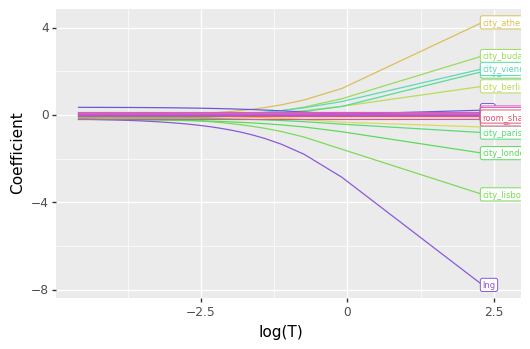

<ggplot: (342800059)>

In [40]:
#coefs_lasso = pd.DataFrame()
#auc_list = []

#for threshold in Cs:
  #model = sklearn.linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C=threshold)
  #tempmodel = model.fit(X_train_pp, Y_train)
  #coefs_lasso = pd.concat([coefs_lasso, pd.Series(tempmodel.coef_[0]).to_frame().T], ignore_index=True)
  #pred = tempmodel.predict(X_test_pp)
  #fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred, pos_label=1)
  #auc_list.append(metrics.auc(fpr, tpr))

#arrests_lasso_plt = coefs_lasso
#arrests_lasso_plt.rename(columns={0: 'year', 1: 'age',
                                  #2: 'checks', 3: 'race_Black',
                                  #4: 'sex_Male', 5: 'employed_Yes',
                                  #6: 'citizen_Yes'}, inplace = True)

#arrests_lasso_plt['Threshold'] = Cs

#arrests_lasso_plt_melt = pd.melt(arrests_lasso_plt, id_vars = 'Threshold', 
                                #var_name = 'Variable', value_name = 'Coefficient')
                                
#max_T = arrests_lasso_plt_melt['Threshold'].loc[arrests_lasso_plt_melt.shape[0]-1]

#plt_label = arrests_lasso_plt_melt[(arrests_lasso_plt_melt['Threshold'] == max_T)]

#(p9.ggplot(arrests_lasso_plt_melt, p9.aes(x = 'Threshold', y = 'Coefficient', 
                                          #color = 'Variable')) +
  #p9.geom_line() +
  #p9.theme(legend_position = "none") +
  #p9.geom_label(inherit_aes = False, data = plt_label, 
                #mapping = p9.aes(label = 'Variable', x = 0.2, 
                                 #y = 'Coefficient', color = 'Variable')))
        
alphas = np.arange(0.1, 100, 1)

Threshold = []
coefs_ridge = pd.DataFrame()

for threshold in alphas:
  model = sklearn.linear_model.Ridge(alpha = threshold)
  tempmodel = model.fit(X_pp, Y)
  coefs_ridge = pd.concat([coefs_ridge, pd.Series(tempmodel.coef_).to_frame().T])
  Threshold.append(np.log(1/threshold))
  

AirBnB_ridge_plt = coefs_ridge
AirBnB_ridge_plt.rename(columns={0: 'room_shared', 1: 'room_private', 2: 'person_capacity', 
                                 3: 'host_is_superhost', 4: 'multi', 5: 'biz', 
                                 6: 'cleanliness_rating', 7: 'guest_satisfaction_overall', 8: 'bedrooms', 
                                 9: 'dist', 10: 'metro_dist', 11: 'attr_index', 
                                 12: 'rest_index', 13: 'lng', 14: 'lat', 
                                 15: 'city_athens', 16: 'city_barcelona', 17: 'city_berlin', 
                                 18: 'city_budapest', 19: 'city_lisbon', 20: 'city_london', 
                                 21: 'city_paris', 22: 'city_rome', 23: 'city_vienna', 
                                 24: 'dayType_weekends'}, 
                                 inplace = True)

AirBnB_ridge_plt['Threshold'] = Threshold

AirBnB_ridge_plt_melt = pd.melt(AirBnB_ridge_plt, id_vars = 'Threshold', 
                                  var_name = 'Variable', value_name = 'Coefficient')
                                  
max_T = AirBnB_ridge_plt_melt['Threshold'].loc[0]

plt_label = AirBnB_ridge_plt_melt[(AirBnB_ridge_plt_melt['Threshold'] == max_T)]

import plotnine as p9

(p9.ggplot(AirBnB_ridge_plt_melt, p9.aes(x = 'Threshold', y = 'Coefficient', color = 'Variable')) +
       p9.geom_line() +
       p9.scale_x_continuous(name = "log(T)", limits = [-4.61, 2.6]) + 
       p9.theme(legend_position = "none", figure_size = [6, 3.75]) +
       p9.geom_label(inherit_aes = False, data = plt_label, ha = 'left',
                     mapping = p9.aes(label = 'Variable', x = np.log(1/0.1), # 
                                      y = 'Coefficient', color = 'Variable', size = 1)))        

26. One nice thing to add to this plot would be a vertical line indicating where the regularization parameter actually is so we can quickly draw conclusions. We can do so using the command `p9.geom_vline()` for **V**ertical line. Remember that we can pull the parameter out using `.alpha_`--try and add this line to the plot. Once you've done so, can you find out which variables are helpful? Which has the largest coefficient?

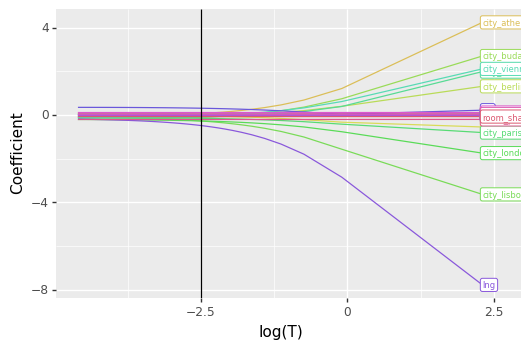

<ggplot: (342885117)>

In [41]:
(p9.ggplot(AirBnB_ridge_plt_melt, p9.aes(x = 'Threshold', y = 'Coefficient', color = 'Variable')) +
       p9.geom_line() +
       p9.scale_x_continuous(name = "log(T)", limits = [-4.61, 2.6]) + 
       p9.geom_vline(xintercept = np.log(1/clf.alpha_)) +
       p9.theme(legend_position = "none", figure_size = [6, 3.75]) +
       p9.geom_label(inherit_aes = False, data = plt_label, ha = 'left',
                     mapping = p9.aes(label = 'Variable', x = np.log(1/0.1), # 
                                      y = 'Coefficient', color = 'Variable', size = 1)))